In [83]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib as mpl
import sys
import os
import gseapy as gp
import pdb
import copy
from scipy import sparse
import anndata
import cerberus


p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

## PolyA gene detection at 0, 1, and 100 TPM

In [3]:
ab = '../talon/human_talon_abundance.tsv'
ver = 'v40_cerberus'

In [18]:
df = pd.read_csv(ab, sep='\t')
df, inds = get_tpm_table(df,
                   how='gene',
                   gene_subset='polya',
                   min_tpm=0)

gene_df, b_counts, b_cat_counts = get_gtf_info(how='gene', ver=ver)

polya_biotypes = ['protein_coding', 'pseudogene', 'lncRNA']
polya_genes = gene_df.loc[gene_df.biotype_category.isin(polya_biotypes), 'gid'].tolist()
n_polya = len(polya_genes)
n_det_polya = len(df.index)

print('Detected {} / {} ({:.3}%) annotated polyA genes'.format(n_det_polya, n_polya, (n_det_polya/n_polya)*100))

tpm_df = df.copy(deep=True)
tpm_dfs = []
tpm_dfs.append(tpm_df)
tpm_dfs.append(tpm_df.loc[(tpm_df >= 1).any(axis=1)])
tpm_dfs.append(tpm_df.loc[(tpm_df >= 100).any(axis=1)])

det_df = pd.DataFrame()
for df, tpm in zip(tpm_dfs, [0,1,100]):
    gene_df, _, _ = get_gtf_info(how='gene', subset='polya', ver=ver, add_stable_gid=True)
    gene_df = gene_df[['gid_stable', 'gname', 'biotype_category']]

    df.reset_index(inplace=True)
    df = df.merge(gene_df, how='left', on='gid_stable')

    df = df[['gid_stable', 'biotype_category']].groupby('biotype_category').count()
    df.rename({'gid_stable':'obs_counts'}, axis=1, inplace=True)

    gene_df = gene_df[['gid_stable', 'biotype_category']].groupby('biotype_category').count()
    gene_df.rename({'gid_stable':'annot_counts'}, axis=1, inplace=True)
    df = df.merge(gene_df, how='left', left_index=True, right_index=True)

    df['perc'] = (df.obs_counts/df.annot_counts)*100
    df = df.sort_values(by='perc', ascending=False)
    df['tpm_thresh'] = tpm
    det_df = pd.concat([det_df, df])
    
det_df = det_df.reset_index()
det_df.head()

In [87]:
det_df

,biotype_category,obs_counts,annot_counts,perc,tpm_thresh
0,protein_coding,19246,19988,96.287773,0
1,lncRNA,12715,17748,71.641875,0
2,pseudogene,7720,14538,53.102215,0
3,protein_coding,18727,19988,93.691215,1
4,lncRNA,10713,17748,60.361731,1
5,pseudogene,4332,14538,29.797771,1
6,protein_coding,9776,19988,48.909346,100
7,lncRNA,254,17748,1.431147,100
8,pseudogene,101,14538,0.694731,100


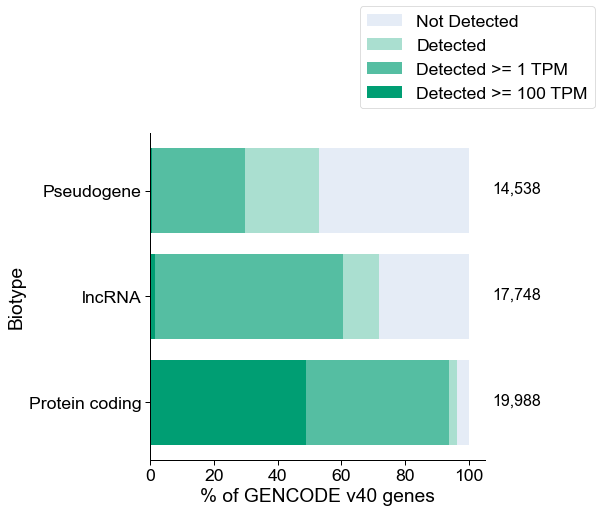

In [86]:
sns.set_context('paper', font_scale=2)
plt.figure(figsize=(6,6))
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
ic_colors, order = get_ic_nov_colors()
gray = get_sector_colors()[0]['simple']
c = ic_colors['Known']
cats = [100,1,0]
c_dict, order = get_shade_colors(c, cats)
order.reverse()
biotypes = ['protein_coding', 'lncRNA', 'pseudogene']
b_dict = {'protein_coding': 'Protein coding',
          'lncRNA': 'lncRNA',
          'pseudogene': 'Pseudogene'}

# https://matplotlib.org/2.0.2/examples/api/barchart_demo.html
def add_n(rects, label):
    ax = plt.gca()
    for rect in rects:
        # height = rect.get_height()
        x = rect.get_y()+rect.get_height()/2.3
        y = rect.get_width()*1.15
        ax.text(y,x,
                '{:,}'.format(label),
                ha='center', va='bottom', size=16)

for b in biotypes:
    x = b_dict[b]
    y = 0
    rects = plt.barh(x, [100], color=gray)
    # add total number of genes
    n = det_df.loc[(det_df.biotype_category == b)&(det_df.tpm_thresh==0), 'annot_counts'].tolist()[0]
    add_n(rects, n)
    
    for c in order:
        curr_y = det_df.loc[(det_df.biotype_category == b)&(det_df.tpm_thresh==c), 'perc'].tolist()[0]
        plt.barh(x, [curr_y], color=c_dict[c])
        y = y+curr_y
    


leg_labels = ['Not Detected', 'Detected', 'Detected >= 1 TPM', 'Detected >= 100 TPM']
plt.legend(leg_labels, bbox_to_anchor=(.6, 1.05))
ax = plt.gca()
leg = ax.get_legend()

# plt.yticks(rotation=90)

plt.ylabel('Biotype')
plt.xlabel('% of GENCODE v40 genes')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fname = 'figures/gene_det_by_biotype.png'
plt.savefig(fname, dpi=500, bbox_inches='tight')
fname = 'figures/gene_det_by_biotype.pdf'
plt.savefig(fname, dpi=500, bbox_inches='tight')